In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from transformers import optimization

import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import AutoAugmentPolicy, AutoAugment
from torchvision.ops.misc import ConvNormActivation, SqueezeExcitation
from functools import partial

import numpy as np
import matplotlib.pyplot as plot
import pandas as pd
import matplotlib.pyplot as plt
import copy
from tqdm.notebook import tqdm
import sklearn.metrics as metrics
import time
import os
import copy
from tqdm import tqdm
from PIL import Image
import csv
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

1.12.1
True


# Set up configs

In [4]:
# Modify the hyperparameters
num_classes = 5  # Number of classes in your dataset
batch_size = 30  # Set up batch size
num_epochs = 100
learning_rate = 0.001  # Set the desired learning rate
early_stopping = False
model_checkpoint_path = '/root/autodl-nas/TXY/models'
tensorboard_dir = '/root/autodl-nas/TXY/tensorbord'
log_file_dir = '/root/autodl-nas/TXY/log'
model_name = 'EfficientNet_b5'

# Define the base directory where the images are located
base_dir = "/root/autodl-nas/TXY/lung_pathology"

# Define paths
dataset_path = "/root/autodl-nas/TXY/lung_pathology"
labels_path = "/root/autodl-nas/TXY/lung_pathology/file.csv"

# Define saved json paths
train_json_path = "/root/autodl-nas/TXY/lung_pathology/train_dataset.json"
val_json_path = "/root/autodl-nas/TXY/lung_pathology/val_dataset.json"
test_json_path = "/root/autodl-nas/TXY/lung_pathology/test_dataset.json"

# Load CSV file and get labels

In [5]:
import os
import random
import json

# Enable interactive mode
plt.ion()

# Load labels and file names from CSV
import pandas as pd
csv_file = pd.read_csv(labels_path)

# Shuffle the file names
file_names = csv_file['filename'].tolist()
random.shuffle(file_names)

# Calculate the number of samples for each split
total_samples = len(file_names)
train_ratio = 0.7
val_ratio = 0.1

num_train = int(total_samples * train_ratio)
num_val = int(total_samples * val_ratio)
num_test = total_samples - num_train - num_val

# Split the file names into train, validation, and test sets
train_file_names = file_names[:num_train]
val_file_names = file_names[num_train:num_train + num_val]
test_file_names = file_names[num_train + num_val:]

# Function to find the label for a given file name
def find_label(file_name):
    return csv_file.loc[csv_file['filename'] == file_name, 'label'].values[0]

# Function to get the file path given the file name
def get_file_path(file_name):
    for root, dirs, files in os.walk(dataset_path):
        if file_name in files:
            return os.path.abspath(os.path.join(root, file_name))

# Create dictionaries for the train, validation, and test sets
train_dict = []
val_dict = []
test_dict = []

# Fill the dictionaries with file paths and labels
for file_name in train_file_names:
    label = find_label(file_name)
    file_path = get_file_path(file_name)  # Complete file path
    train_dict.append({"file_name": file_name, "file_path": file_path, "label": label})

for file_name in val_file_names:
    label = find_label(file_name)
    file_path = get_file_path(file_name)  # Complete file path
    val_dict.append({"file_name": file_name, "file_path": file_path, "label": label})

for file_name in test_file_names:
    label = find_label(file_name)
    file_path = get_file_path(file_name)  # Complete file path
    test_dict.append({"file_name": file_name, "file_path": file_path, "label": label})

# Save the dictionaries as separate JSON files
with open(train_json_path, 'w') as train_file:
    json.dump(train_dict, train_file)

with open(val_json_path, 'w') as val_file:
    json.dump(val_dict, val_file)

with open(test_json_path, 'w') as test_file:
    json.dump(test_dict, test_file)

# Print the summary
print(f"Total samples: {total_samples}")
print(f"Train samples: {num_train}")
print(f"Validation samples: {num_val}")
print(f"Test samples: {num_test}")
print(f"Train set JSON file saved to: {train_json_path}")
print(f"Validation set JSON file saved to: {val_json_path}")
print(f"Test set JSON file saved to: {test_json_path}")


Total samples: 6095
Train samples: 4266
Validation samples: 609
Test samples: 1220
Train set JSON file saved to: /root/autodl-nas/TXY/lung_pathology/train_dataset.json
Validation set JSON file saved to: /root/autodl-nas/TXY/lung_pathology/val_dataset.json
Test set JSON file saved to: /root/autodl-nas/TXY/lung_pathology/test_dataset.json


# Calculate the mean and std for images

In [6]:
import json
import os
import torch
import torchvision.transforms as transforms
from PIL import Image

# Define the transformation for calculating mean and standard deviation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Variables for accumulating pixel values
sum_channels = torch.zeros(3)
sum_squared_diffs = torch.zeros(3)
num_pixels = 0

# Load the JSON file
with open(train_json_path, 'r') as f:
    dataset_dict = json.load(f)

# Function to recursively find image files in a directory
def find_image_files(directory):
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
                image_files.append(os.path.join(root, file))
    return image_files

# Iterate over the images in the dataset
for item in dataset_dict:
    file_name = item['file_name']
    label = item['label']
    
    # Find image file paths based on file name
    image_files = find_image_files(base_dir)
    image_path = None
    for path in image_files:
        if file_name in path:
            image_path = path
            break
    
    if image_path is not None:
        # Load and transform the image
        image = Image.open(image_path)
        tensor_image = transform(image)

        # Accumulate pixel values
        sum_channels += torch.sum(tensor_image, dim=[1, 2])
        sum_squared_diffs += torch.sum((tensor_image - tensor_image.mean(dim=[1, 2], keepdim=True)) ** 2, dim=[1, 2])
        num_pixels += tensor_image.numel() // 3  # Divide by 3 for RGB channels

# Calculate mean and standard deviation
mean = sum_channels / num_pixels
std = torch.sqrt(sum_squared_diffs / num_pixels)

# Initialize lists to store mean and standard deviation values
mean_list = []
std_list = []

# Print mean and standard deviation for each channel
channel_names = ['R', 'G', 'B']
for i, channel in enumerate(channel_names):
    print(f"Channel {channel}: Mean={mean[i]:.3f}, Std={std[i]:.3f}")
    # Append mean and std values to the respective lists
    mean_list.append(mean[i].item())
    std_list.append(std[i].item())

# Print the lists
print("Mean List:", mean_list)
print("Std List:", std_list)


Channel R: Mean=0.749, Std=0.124
Channel G: Mean=0.574, Std=0.161
Channel B: Mean=0.702, Std=0.099
Mean List: [0.7487631440162659, 0.5741699934005737, 0.701752781867981]
Std List: [0.1239641010761261, 0.16146358847618103, 0.09935591369867325]


In [7]:
import imageio
import torch

# Load the TIFF image
image_path = '/root/autodl-nas/TXY/lung_pathology/Blank/new_0_0__2_.tif'
image = imageio.imread(image_path)

# Convert the image to a PyTorch tensor
tensor_image = torch.from_numpy(image)

# Check the shape of the tensor
print(tensor_image.shape)


torch.Size([1000, 1000, 3])


/tmp/ipykernel_887/1360503400.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


In [8]:
import imageio
import torch

# Load the TIFF image
image_path = '/root/autodl-nas/TXY/lung_pathology/CIS/1-1.tif'
image = imageio.imread(image_path)

# Convert the image to a PyTorch tensor
tensor_image = torch.from_numpy(image)

# Check the shape of the tensor
print(tensor_image.shape)

torch.Size([1000, 1000, 3])


/tmp/ipykernel_887/1493541591.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


# Dataset and DataLoaders

In [9]:
import json
import torch
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Define the transformations and augmentation for train and val sets
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to a fixed size
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=mean_list, std=std_list),  # Normalize the image
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to a fixed size
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=mean_list, std=std_list),  # Normalize the image
])


class CustomDataset(Dataset):
    def __init__(self, json_path, transform=None):
        self.data = []
        self.transform = transform
        self.img_paths = []
        self.labels = []

        # Load the JSON file
        with open(json_path, 'r') as f:
            json_data = json.load(f)
        
        # Process each item in the JSON file
        for item in json_data:
            image_path = item['file_path']
            label = item['label']
            self.data.append((image_path, label))
            self.img_paths.append(image_path)
            self.labels.append(label)
        
        # Get the class names from the JSON file
        self.class_names = list(set(item['label'] for item in json_data))
    
    def __getitem__(self, index):
        image_path, label = self.data[index]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label
    
    def __len__(self):
        return len(self.data)

# Create datasets and data loaders
image_datasets = {"train": CustomDataset(train_json_path, transform=train_transform), 
                  "val": CustomDataset(val_json_path, transform=val_transform), 
                  "test": CustomDataset(test_json_path, transform=val_transform)} # Use val_transform for test as an example

image_dataloader = {"train": DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True), 
                    "val": DataLoader(image_datasets['val'], batch_size=batch_size), 
                    "test": DataLoader(image_datasets['test'], batch_size=batch_size)}


# Get the sizes of the datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# Get the class names
class_names_train = image_datasets['train'].class_names
class_names_val = image_datasets['val'].class_names
class_names_test = image_datasets['test'].class_names

# Print the sizes of the datasets and class names
print("Train dataset size:", dataset_sizes['train'])
print("Validation dataset size:", dataset_sizes['val'])
print("Test dataset size:", dataset_sizes['test'])
print("Train batches:", len(image_dataloader['train']))
print("Validation batches:", len(image_dataloader['val']))
print("Test batches:", len(image_dataloader['test']))
print("Class names-Train set:", class_names_train)
print("Class names-Val set:", class_names_train)
print("Class names-Test set:", class_names_train)


Train dataset size: 4266
Validation dataset size: 609
Test dataset size: 1220
Train batches: 143
Validation batches: 21
Test batches: 41
Class names-Train set: ['IA', 'Normal', 'MIA', 'CIS', 'Blank']
Class names-Val set: ['IA', 'Normal', 'MIA', 'CIS', 'Blank']
Class names-Test set: ['IA', 'Normal', 'MIA', 'CIS', 'Blank']


In [10]:
# Set up label_map 
label_map = {
    'Blank': 0,
    'Normal': 1,
    'CIS': 2,
    'MIA': 3,
    'IA': 4
}

label_map_inv = {v: k for k, v in label_map.items()}  # Define inverse mapping

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('using device: {}'.format(device))

using device: cuda:0


# imshow function for tensor image

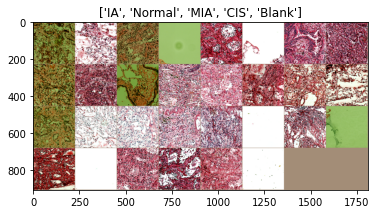

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

def imshow(imgs, title=None):
    imgs = imgs.numpy().transpose((1, 2, 0))
    mean = np.array([0.642, 0.554, 0.468])
    std = np.array([0.246, 0.249, 0.263])
    imgs = std * imgs + mean
    imgs = np.clip(imgs, 0, 1)
    plt.imshow(imgs)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of inputs and classes
inputs, classes = next(iter(image_dataloader['train']))
imgs = torchvision.utils.make_grid(inputs)
imshow(imgs, title=class_names_train)

# Train function and its pipeline

In [13]:
import time
import datetime
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import metrics
import os
from torch.utils.tensorboard import SummaryWriter

def train(model, criterion, optimizer, scheduler, num_epochs=30, early_stopping=True, model_checkpoint_path=None, model_name='ResNet18', tensorboard_dir=None, log_file_dir=None):
    last_loss = 100
    patience = 5
    trigger_times = 0

    total_start = time.time()

    total_train_accuracy = []
    total_train_loss = []
    total_val_accuracy = []
    total_val_loss = []
    total_train_auroc = []  # List to store train set AUROC values
    total_val_auroc = []  # List to store val set AUROC values
    learning_rates = []  # List to store learning rates
    total_steps = []  # List to store steps

    best_model_weight = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')

    if tensorboard_dir is not None:
        os.makedirs(tensorboard_dir, exist_ok=True)
        writer = SummaryWriter(tensorboard_dir)

    # Generate datetime suffix
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    # Generate log file path with datetime suffix
    if log_file_dir is not None:
        os.makedirs(log_file_dir, exist_ok=True)
        log_file_path = os.path.join(log_file_dir, f"log_{timestamp}.txt")
        log_file = open(log_file_path, 'w')
    else:
        log_file = None        

    for epoch in range(num_epochs):
        start = time.time()
        print('Epoch {} / {}'.format(epoch, num_epochs-1))
        print('-' * 20)

        epoch_loss = 0.0  # Initialize epoch loss

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_predictions = []  # List to store predicted probabilities
            all_labels = []  # List to store true labels

            data_loader = tqdm(image_dataloader[phase], desc='{} Phase'.format(phase.capitalize()))

            for index, (inputs, labels) in enumerate(data_loader):
                inputs = inputs.to(device)
                labels = torch.tensor([label_map[label] for label in labels]).to(device)  # Convert labels to numerical values

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    predictions = torch.softmax(outputs, dim=1)
                    all_predictions.append(predictions.detach().cpu().numpy())
                    all_labels.append(labels.detach().cpu().numpy())
                    loss.backward()
                    optimizer.step()

                    current_step = index + len(image_dataloader[phase]) * epoch
                    total_steps.append(current_step)  # Store the steps
                    learning_rates.append(optimizer.param_groups[0]['lr'])  # Store the learning rate at each batch or step

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'val':
                    predictions = torch.softmax(outputs, dim=1)
                    all_predictions.append(predictions.detach().cpu().numpy())
                    all_labels.append(labels.detach().cpu().numpy())

            if phase == 'train':
                scheduler.step()  # Update the learning rate scheduler

            epoch_loss = running_loss / dataset_sizes[phase]  # Assign epoch loss
            epoch_accuracy = running_corrects.float() / dataset_sizes[phase]

            if phase == 'train':
                total_train_loss.append(epoch_loss)
                total_train_accuracy.append(epoch_accuracy)
                print('{} Loss: {:.5f} Accuracy: {:.5f}'.format(phase, epoch_loss, epoch_accuracy))
                if len(all_predictions) > 0 and len(all_labels) > 0:
                    all_predictions = np.concatenate(all_predictions)
                    all_labels = np.concatenate(all_labels)
                    if len(image_datasets['train'].class_names) == 2:
                        train_auroc = metrics.roc_auc_score(all_labels, all_predictions[:, 1], average='binary')
                    else:
                        train_auroc = []
                        for i in range(len(image_datasets['train'].class_names)):
                            class_labels = (all_labels == i).astype(int)
                            class_probs = all_predictions[:, i]
                            if np.sum(class_labels) > 0 and np.sum(1 - class_labels) > 0:
                                class_auroc = metrics.roc_auc_score(class_labels, class_probs)
                                train_auroc.append(class_auroc)
                        train_auroc = np.mean(train_auroc)
                    total_train_auroc.append(train_auroc)
                    print('Train AUROC: {:.5f}'.format(train_auroc))

                    if tensorboard_dir is not None:
                        writer.add_scalar('Train AUROC', train_auroc, epoch)

            if phase == 'val':
                total_val_loss.append(epoch_loss)
                total_val_accuracy.append(epoch_accuracy)
                print('{} Loss: {:.5f} Accuracy: {:.5f}'.format(phase, epoch_loss, epoch_accuracy))
                if len(all_predictions) > 0 and len(all_labels) > 0:
                    all_predictions = np.concatenate(all_predictions)
                    all_labels = np.concatenate(all_labels)
                    if len(image_datasets['train'].class_names) == 2:
                        # For binary classification, use 'binary' average
                        auroc = metrics.roc_auc_score(all_labels, all_predictions[:, 1], average='binary')
                    else:
                        # For multi-class classification, calculate AUROC per class using 'ovr' strategy
                        auroc = []
                        for i in range(len(image_datasets['train'].class_names)):
                            class_labels = (all_labels == i).astype(int)
                            class_probs = all_predictions[:, i]
                            if np.sum(class_labels) > 0 and np.sum(1 - class_labels) > 0:
                                class_auroc = metrics.roc_auc_score(class_labels, class_probs)
                                auroc.append(class_auroc)
                        auroc = np.mean(auroc)
                    total_val_auroc.append(auroc)
                    print('Val AUROC: {:.5f}'.format(auroc))

                    if tensorboard_dir is not None:
                        writer.add_scalar('Val AUROC', auroc, epoch)

            if phase == 'val' and epoch_accuracy > best_acc:
                best_acc = epoch_accuracy
                best_loss = epoch_loss
                best_model_weight = copy.deepcopy(model.state_dict())
                # Save the best model state dictionary
                if model_checkpoint_path is not None:
                    os.makedirs(model_checkpoint_path, exist_ok=True)
                    checkpoint_path = os.path.join(model_checkpoint_path, '{}_best_model.pt'.format(model_name))
                    torch.save(best_model_weight, checkpoint_path)

            if early_stopping and phase == 'val':
                if last_loss < epoch_loss:
                    trigger_times += 1
                    if trigger_times >= patience:
                        print('Early stopping at epoch {}'.format(epoch))
                        total_time_elapsed = np.round(time.time() - total_start, 3)
                        print('Completed training in {:0f}m {:03f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))
                        print('Best Accuracy: {}, Best Loss: {}'.format(best_acc, best_loss))
                        model.load_state_dict(best_model_weight)
                        return model, total_train_accuracy, total_train_loss, total_train_auroc, total_val_accuracy, total_val_loss, total_val_auroc
                else:
                    trigger_times = 0
                last_loss = epoch_loss

        if model_checkpoint_path and epoch % 10 == 0:
            os.makedirs(model_checkpoint_path, exist_ok=True)  # Create the folder if it doesn't exist
            checkpoint_path = os.path.join(model_checkpoint_path, '{}_epoch_{}.pt'.format(model_name, epoch))
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'epoch': epoch
            }, checkpoint_path)

        end = np.round(time.time() - start, 3)
        print('Epoch {}: {}s\n'.format(epoch, end))

        if tensorboard_dir is not None:
            writer.add_scalar('Epoch Loss/Train', total_train_loss[-1], epoch)
            writer.add_scalar('Epoch Accuracy/Train', total_train_accuracy[-1], epoch)
            writer.add_scalar('Epoch Loss/Validation', total_val_loss[-1], epoch)
            writer.add_scalar('Epoch Accuracy/Validation', total_val_accuracy[-1], epoch)
            writer.add_scalar('Learning Rate', learning_rates[-1], current_step)

    total_time_elapsed = np.round(time.time() - total_start, 3)
    print('Completed training in {:0f}m {:03f}s'.format(total_time_elapsed // 60, total_time_elapsed % 60))
    print('Best Accuracy: {}, Best Loss: {}'.format(best_acc, best_loss))

    model.load_state_dict(best_model_weight)

    total_train_accuracy = [acc.item() for acc in total_train_accuracy]
    total_val_accuracy = [acc.item() for acc in total_val_accuracy]

    # Save training metrics to a log file
    if log_file is not None:
        with log_file:
            log_file.write('Total Train Accuracy: {}\n'.format(total_train_accuracy))
            log_file.write('Total Train Loss: {}\n'.format(total_train_loss))
            log_file.write('Total Train AUROC: {}\n'.format(total_train_auroc))
            log_file.write('Total Validation Accuracy: {}\n'.format(total_val_accuracy))
            log_file.write('Total Validation Loss: {}\n'.format(total_val_loss))
            log_file.write('Total Validation AUROC: {}\n'.format(total_val_auroc))

    # TensorBoard visualization
    if tensorboard_dir is not None:
        writer.close()
    

    # Plotting training metrics
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 2, 1)
    plt.plot(range(num_epochs), total_train_loss, label='Train')
    plt.plot(range(num_epochs), total_val_loss, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(range(num_epochs), total_train_accuracy, label='Train')
    plt.plot(range(num_epochs), total_val_accuracy, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(range(num_epochs), total_val_auroc, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('AUROC')
    plt.title('AUROC')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(total_steps, learning_rates)
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate')
    plt.legend()

    plt.tight_layout()
    plt.show()    
    

    return model, total_train_accuracy, total_train_loss, total_train_auroc, total_val_accuracy, total_val_loss, total_val_auroc


# Network Structure

In [14]:
import torch
from torchsummary import summary
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Load pretrained EfficientNet_b5 model
model = torchvision.models.efficientnet_b5(pretrained=True)

# summary(model, input_size=(3, 224, 224))
# print("Original model: \n", model)

model.features[0] = ConvNormActivation(
    in_channels=3,
    out_channels=48,
    kernel_size=3,
    stride=2,
    norm_layer=partial(nn.BatchNorm2d, eps=0.001, momentum=0.01),
    activation_layer=nn.SiLU)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=2048, out_features=num_classes, bias=True))

model = model.to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.classifier.parameters(), lr=learning_rate, momentum=0.9) # Only optimize the parameters of the classifier layer, ignoring the parameters of other parts of the model
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) # Optimizes all the parameters of the entire model
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=learning_rate, 
                                                epochs=num_epochs, 
                                                steps_per_epoch=1, 
                                                pct_start=0.3, 
                                                anneal_strategy='cos', 
                                                cycle_momentum=True, 
                                                base_momentum=0.85, 
                                                max_momentum=0.95)

# scheduler = optimization.get_linear_schedule_with_warmup(optimizer, 
#                                                          num_warmup_steps=3, 
#                                                          num_training_steps=num_epochs)

# summary(model, input_size=(3, 224, 224))
# print("Revised model: \n", model)


/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/miniconda3/lib/python3.8/site-packages/torchvision/ops/misc.py:114: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


# Train

Epoch 0 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:28<00:00,  1.62it/s]


train Loss: 1.58726 Accuracy: 0.27098
Train AUROC: 0.55924


Val Phase: 100%|██████████| 21/21 [00:37<00:00,  1.77s/it]


val Loss: 1.59003 Accuracy: 0.29064
Val AUROC: 0.58362
Epoch 0: 126.763s

Epoch 1 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:16<00:00,  1.87it/s]


train Loss: 1.49277 Accuracy: 0.40788
Train AUROC: 0.67134


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.61it/s]


val Loss: 1.48235 Accuracy: 0.45156
Val AUROC: 0.70904
Epoch 1: 84.969s

Epoch 2 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:15<00:00,  1.89it/s]


train Loss: 1.40310 Accuracy: 0.47562
Train AUROC: 0.72906


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.64it/s]


val Loss: 1.37230 Accuracy: 0.53038
Val AUROC: 0.77237
Epoch 2: 84.341s

Epoch 3 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:15<00:00,  1.89it/s]


train Loss: 1.30443 Accuracy: 0.51102
Train AUROC: 0.77494


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.68it/s]


val Loss: 1.27208 Accuracy: 0.54516
Val AUROC: 0.80786
Epoch 3: 83.802s

Epoch 4 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:15<00:00,  1.90it/s]


train Loss: 1.21571 Accuracy: 0.54618
Train AUROC: 0.80277


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.74it/s]


val Loss: 1.18071 Accuracy: 0.56979
Val AUROC: 0.83499
Epoch 4: 83.485s

Epoch 5 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:15<00:00,  1.89it/s]


train Loss: 1.13121 Accuracy: 0.57126
Train AUROC: 0.82973


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.63it/s]


val Loss: 1.09225 Accuracy: 0.60427
Val AUROC: 0.86431
Epoch 5: 84.279s

Epoch 6 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:15<00:00,  1.89it/s]


train Loss: 1.06095 Accuracy: 0.59376
Train AUROC: 0.84549


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.74it/s]


val Loss: 1.02172 Accuracy: 0.62397
Val AUROC: 0.87703
Epoch 6: 83.598s

Epoch 7 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:15<00:00,  1.88it/s]


train Loss: 0.99341 Accuracy: 0.61322
Train AUROC: 0.86201


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


val Loss: 0.95380 Accuracy: 0.62890
Val AUROC: 0.88731
Epoch 7: 83.947s

Epoch 8 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:16<00:00,  1.87it/s]


train Loss: 0.93406 Accuracy: 0.63174
Train AUROC: 0.87540


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.56it/s]


val Loss: 0.86909 Accuracy: 0.66174
Val AUROC: 0.90429
Epoch 8: 84.998s

Epoch 9 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:16<00:00,  1.88it/s]


train Loss: 0.86670 Accuracy: 0.65682
Train AUROC: 0.88862


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.78it/s]


val Loss: 0.80447 Accuracy: 0.68145
Val AUROC: 0.91316
Epoch 9: 83.97s

Epoch 10 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:16<00:00,  1.87it/s]


train Loss: 0.81451 Accuracy: 0.67065
Train AUROC: 0.89567


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.62it/s]


val Loss: 0.73812 Accuracy: 0.71757
Val AUROC: 0.92450
Epoch 10: 85.625s

Epoch 11 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:16<00:00,  1.88it/s]


train Loss: 0.76593 Accuracy: 0.68519
Train AUROC: 0.90645


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.75it/s]


val Loss: 0.69332 Accuracy: 0.72085
Val AUROC: 0.92742
Epoch 11: 84.095s

Epoch 12 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:23<00:00,  1.72it/s]


train Loss: 0.72499 Accuracy: 0.69972
Train AUROC: 0.91314


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.56it/s]


val Loss: 0.63960 Accuracy: 0.74220
Val AUROC: 0.93425
Epoch 12: 91.846s

Epoch 13 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:26<00:00,  1.66it/s]


train Loss: 0.68848 Accuracy: 0.71566
Train AUROC: 0.91772


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.19it/s]


val Loss: 0.61340 Accuracy: 0.76026
Val AUROC: 0.93665
Epoch 13: 96.404s

Epoch 14 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:25<00:00,  1.68it/s]


train Loss: 0.64423 Accuracy: 0.72808
Train AUROC: 0.92451


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]


val Loss: 0.57495 Accuracy: 0.76190
Val AUROC: 0.94346
Epoch 14: 94.954s

Epoch 15 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:24<00:00,  1.69it/s]


train Loss: 0.62958 Accuracy: 0.73113
Train AUROC: 0.92606


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.40it/s]


val Loss: 0.55890 Accuracy: 0.78161
Val AUROC: 0.94619
Epoch 15: 93.952s

Epoch 16 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:27<00:00,  1.64it/s]


train Loss: 0.61104 Accuracy: 0.74824
Train AUROC: 0.92971


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


val Loss: 0.55933 Accuracy: 0.77668
Val AUROC: 0.94504
Epoch 16: 97.11s

Epoch 17 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:24<00:00,  1.70it/s]


train Loss: 0.58344 Accuracy: 0.75363
Train AUROC: 0.93423


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.60it/s]


val Loss: 0.50713 Accuracy: 0.77504
Val AUROC: 0.95153
Epoch 17: 92.408s

Epoch 18 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:18<00:00,  1.83it/s]


train Loss: 0.57745 Accuracy: 0.75504
Train AUROC: 0.93550


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.14it/s]


val Loss: 0.49596 Accuracy: 0.79146
Val AUROC: 0.95507
Epoch 18: 88.724s

Epoch 19 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:22<00:00,  1.72it/s]


train Loss: 0.55457 Accuracy: 0.76676
Train AUROC: 0.94121


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.68it/s]


val Loss: 0.48190 Accuracy: 0.79803
Val AUROC: 0.95565
Epoch 19: 91.225s

Epoch 20 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:17<00:00,  1.83it/s]


train Loss: 0.52489 Accuracy: 0.77520
Train AUROC: 0.94462


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.33it/s]


val Loss: 0.46779 Accuracy: 0.77833
Val AUROC: 0.95531
Epoch 20: 88.153s

Epoch 21 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:16<00:00,  1.86it/s]


train Loss: 0.51878 Accuracy: 0.78880
Train AUROC: 0.94717


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


val Loss: 0.46542 Accuracy: 0.80131
Val AUROC: 0.95801
Epoch 21: 84.992s

Epoch 22 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:16<00:00,  1.86it/s]


train Loss: 0.51595 Accuracy: 0.78575
Train AUROC: 0.94643


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.48it/s]


val Loss: 0.46998 Accuracy: 0.80131
Val AUROC: 0.95891
Epoch 22: 85.197s

Epoch 23 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:16<00:00,  1.87it/s]


train Loss: 0.49438 Accuracy: 0.79231
Train AUROC: 0.95176


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.65it/s]


val Loss: 0.43732 Accuracy: 0.82102
Val AUROC: 0.95978
Epoch 23: 84.849s

Epoch 24 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:22<00:00,  1.73it/s]


train Loss: 0.47565 Accuracy: 0.80075
Train AUROC: 0.95446


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.28it/s]


val Loss: 0.43246 Accuracy: 0.80952
Val AUROC: 0.96053
Epoch 24: 91.977s

Epoch 25 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:16<00:00,  1.88it/s]


train Loss: 0.47494 Accuracy: 0.79466
Train AUROC: 0.95485


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.81it/s]


val Loss: 0.44741 Accuracy: 0.80788
Val AUROC: 0.95861
Epoch 25: 83.722s

Epoch 26 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:21<00:00,  1.76it/s]


train Loss: 0.45430 Accuracy: 0.80825
Train AUROC: 0.95859


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.47it/s]


val Loss: 0.42169 Accuracy: 0.80952
Val AUROC: 0.96217
Epoch 26: 89.567s

Epoch 27 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:22<00:00,  1.73it/s]


train Loss: 0.45187 Accuracy: 0.81950
Train AUROC: 0.95923


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.29it/s]


val Loss: 0.44334 Accuracy: 0.80460
Val AUROC: 0.95910
Epoch 27: 91.65s

Epoch 28 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:23<00:00,  1.71it/s]


train Loss: 0.42834 Accuracy: 0.82654
Train AUROC: 0.96393


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.55it/s]


val Loss: 0.41557 Accuracy: 0.80788
Val AUROC: 0.96386
Epoch 28: 91.982s

Epoch 29 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:26<00:00,  1.66it/s]


train Loss: 0.41742 Accuracy: 0.82630
Train AUROC: 0.96389


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.46it/s]


val Loss: 0.42327 Accuracy: 0.82923
Val AUROC: 0.96255
Epoch 29: 95.161s

Epoch 30 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:21<00:00,  1.76it/s]


train Loss: 0.41672 Accuracy: 0.83075
Train AUROC: 0.96383


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.57it/s]


val Loss: 0.42440 Accuracy: 0.80952
Val AUROC: 0.96300
Epoch 30: 90.006s

Epoch 31 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:23<00:00,  1.70it/s]


train Loss: 0.38626 Accuracy: 0.84130
Train AUROC: 0.96971


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.83it/s]


val Loss: 0.43369 Accuracy: 0.81938
Val AUROC: 0.96132
Epoch 31: 91.329s

Epoch 32 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:22<00:00,  1.73it/s]


train Loss: 0.37072 Accuracy: 0.84927
Train AUROC: 0.97169


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.46it/s]


val Loss: 0.40329 Accuracy: 0.81938
Val AUROC: 0.96482
Epoch 32: 91.432s

Epoch 33 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:17<00:00,  1.84it/s]


train Loss: 0.35929 Accuracy: 0.85560
Train AUROC: 0.97356


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.74it/s]


val Loss: 0.41362 Accuracy: 0.81773
Val AUROC: 0.96420
Epoch 33: 85.402s

Epoch 34 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:21<00:00,  1.76it/s]


train Loss: 0.34929 Accuracy: 0.85842
Train AUROC: 0.97508


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.53it/s]


val Loss: 0.39580 Accuracy: 0.83580
Val AUROC: 0.96645
Epoch 34: 89.888s

Epoch 35 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:20<00:00,  1.77it/s]


train Loss: 0.34187 Accuracy: 0.86404
Train AUROC: 0.97629


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.30it/s]


val Loss: 0.38654 Accuracy: 0.82430
Val AUROC: 0.96711
Epoch 35: 89.801s

Epoch 36 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:22<00:00,  1.74it/s]


train Loss: 0.32876 Accuracy: 0.86896
Train AUROC: 0.97836


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.06it/s]


val Loss: 0.41594 Accuracy: 0.81609
Val AUROC: 0.96298
Epoch 36: 92.255s

Epoch 37 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:22<00:00,  1.74it/s]


train Loss: 0.31359 Accuracy: 0.87553
Train AUROC: 0.98053


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.60it/s]


val Loss: 0.39249 Accuracy: 0.81773
Val AUROC: 0.96547
Epoch 37: 90.416s

Epoch 38 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:25<00:00,  1.67it/s]


train Loss: 0.28904 Accuracy: 0.88561
Train AUROC: 0.98277


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.10it/s]


val Loss: 0.42859 Accuracy: 0.82923
Val AUROC: 0.96381
Epoch 38: 95.544s

Epoch 39 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:25<00:00,  1.68it/s]


train Loss: 0.30432 Accuracy: 0.88115
Train AUROC: 0.98102


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.57it/s]


val Loss: 0.39346 Accuracy: 0.81445
Val AUROC: 0.96621
Epoch 39: 93.414s

Epoch 40 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:25<00:00,  1.67it/s]


train Loss: 0.27185 Accuracy: 0.88889
Train AUROC: 0.98413


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.08it/s]


val Loss: 0.49045 Accuracy: 0.79803
Val AUROC: 0.95765
Epoch 40: 96.467s

Epoch 41 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:25<00:00,  1.68it/s]


train Loss: 0.24684 Accuracy: 0.90670
Train AUROC: 0.98769


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]


val Loss: 0.41325 Accuracy: 0.82102
Val AUROC: 0.96387
Epoch 41: 94.236s

Epoch 42 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:25<00:00,  1.68it/s]


train Loss: 0.25828 Accuracy: 0.90506
Train AUROC: 0.98656


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.18it/s]


val Loss: 0.46920 Accuracy: 0.81445
Val AUROC: 0.96104
Epoch 42: 94.801s

Epoch 43 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:25<00:00,  1.66it/s]


train Loss: 0.24426 Accuracy: 0.90975
Train AUROC: 0.98753


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.31it/s]


val Loss: 0.42696 Accuracy: 0.83251
Val AUROC: 0.96464
Epoch 43: 95.05s

Epoch 44 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:25<00:00,  1.66it/s]


train Loss: 0.23303 Accuracy: 0.91210
Train AUROC: 0.98890


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.10it/s]


val Loss: 0.41946 Accuracy: 0.83580
Val AUROC: 0.96506
Epoch 44: 96.065s

Epoch 45 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:26<00:00,  1.64it/s]


train Loss: 0.23020 Accuracy: 0.91280
Train AUROC: 0.98913


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.08it/s]


val Loss: 0.42705 Accuracy: 0.82266
Val AUROC: 0.96377
Epoch 45: 97.104s

Epoch 46 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:27<00:00,  1.63it/s]


train Loss: 0.21700 Accuracy: 0.91983
Train AUROC: 0.99028


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.40it/s]


val Loss: 0.44159 Accuracy: 0.81938
Val AUROC: 0.96425
Epoch 46: 96.404s

Epoch 47 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:26<00:00,  1.65it/s]


train Loss: 0.18765 Accuracy: 0.93202
Train AUROC: 0.99270


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.10it/s]


val Loss: 0.43641 Accuracy: 0.82266
Val AUROC: 0.96451
Epoch 47: 96.695s

Epoch 48 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:23<00:00,  1.71it/s]


train Loss: 0.20198 Accuracy: 0.92499
Train AUROC: 0.99164


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.39it/s]


val Loss: 0.41400 Accuracy: 0.82594
Val AUROC: 0.96697
Epoch 48: 92.552s

Epoch 49 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:26<00:00,  1.65it/s]


train Loss: 0.19080 Accuracy: 0.93460
Train AUROC: 0.99269


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.05it/s]


val Loss: 0.44813 Accuracy: 0.83908
Val AUROC: 0.96547
Epoch 49: 97.21s

Epoch 50 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:24<00:00,  1.70it/s]


train Loss: 0.16912 Accuracy: 0.94187
Train AUROC: 0.99451


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.39it/s]


val Loss: 0.42609 Accuracy: 0.82594
Val AUROC: 0.96646
Epoch 50: 93.806s

Epoch 51 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:27<00:00,  1.63it/s]


train Loss: 0.17658 Accuracy: 0.93812
Train AUROC: 0.99410


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.06it/s]


val Loss: 0.44115 Accuracy: 0.82923
Val AUROC: 0.96482
Epoch 51: 97.92s

Epoch 52 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:26<00:00,  1.66it/s]


train Loss: 0.15749 Accuracy: 0.94444
Train AUROC: 0.99505


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.07it/s]


val Loss: 0.48757 Accuracy: 0.81938
Val AUROC: 0.96281
Epoch 52: 96.216s

Epoch 53 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:26<00:00,  1.66it/s]


train Loss: 0.14820 Accuracy: 0.94679
Train AUROC: 0.99564


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


val Loss: 0.49718 Accuracy: 0.82923
Val AUROC: 0.96337
Epoch 53: 95.837s

Epoch 54 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:27<00:00,  1.64it/s]


train Loss: 0.15936 Accuracy: 0.94140
Train AUROC: 0.99462


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.39it/s]


val Loss: 0.47183 Accuracy: 0.82266
Val AUROC: 0.96315
Epoch 54: 96.148s

Epoch 55 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:16<00:00,  1.87it/s]


train Loss: 0.14509 Accuracy: 0.94890
Train AUROC: 0.99584


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.56it/s]


val Loss: 0.48572 Accuracy: 0.83251
Val AUROC: 0.96368
Epoch 55: 84.784s

Epoch 56 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:17<00:00,  1.84it/s]


train Loss: 0.13996 Accuracy: 0.94820
Train AUROC: 0.99603


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.61it/s]


val Loss: 0.45216 Accuracy: 0.83744
Val AUROC: 0.96563
Epoch 56: 85.98s

Epoch 57 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:19<00:00,  1.79it/s]


train Loss: 0.13335 Accuracy: 0.95007
Train AUROC: 0.99659


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.73it/s]


val Loss: 0.47626 Accuracy: 0.83744
Val AUROC: 0.96435
Epoch 57: 87.553s

Epoch 58 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:21<00:00,  1.75it/s]


train Loss: 0.11653 Accuracy: 0.96085
Train AUROC: 0.99726


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.30it/s]


val Loss: 0.49683 Accuracy: 0.82594
Val AUROC: 0.96454
Epoch 58: 90.956s

Epoch 59 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:17<00:00,  1.85it/s]


train Loss: 0.12769 Accuracy: 0.95663
Train AUROC: 0.99669


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.83it/s]


val Loss: 0.47128 Accuracy: 0.83744
Val AUROC: 0.96509
Epoch 59: 84.874s

Epoch 60 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:17<00:00,  1.84it/s]


train Loss: 0.12024 Accuracy: 0.95851
Train AUROC: 0.99715


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.58it/s]


val Loss: 0.47143 Accuracy: 0.83580
Val AUROC: 0.96493
Epoch 60: 86.31s

Epoch 61 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:20<00:00,  1.77it/s]


train Loss: 0.12146 Accuracy: 0.95546
Train AUROC: 0.99720


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.64it/s]


val Loss: 0.52380 Accuracy: 0.82102
Val AUROC: 0.96089
Epoch 61: 88.774s

Epoch 62 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:20<00:00,  1.78it/s]


train Loss: 0.09847 Accuracy: 0.96882
Train AUROC: 0.99805


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


val Loss: 0.49132 Accuracy: 0.82923
Val AUROC: 0.96488
Epoch 62: 90.256s

Epoch 63 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:21<00:00,  1.76it/s]


train Loss: 0.11166 Accuracy: 0.96296
Train AUROC: 0.99742


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.86it/s]


val Loss: 0.51408 Accuracy: 0.82594
Val AUROC: 0.96466
Epoch 63: 88.813s

Epoch 64 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:22<00:00,  1.74it/s]


train Loss: 0.09560 Accuracy: 0.97000
Train AUROC: 0.99826


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


val Loss: 0.51172 Accuracy: 0.82266
Val AUROC: 0.96534
Epoch 64: 91.757s

Epoch 65 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:17<00:00,  1.85it/s]


train Loss: 0.09442 Accuracy: 0.96882
Train AUROC: 0.99828


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.84it/s]


val Loss: 0.51088 Accuracy: 0.82923
Val AUROC: 0.96442
Epoch 65: 84.868s

Epoch 66 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:21<00:00,  1.75it/s]


train Loss: 0.09600 Accuracy: 0.96906
Train AUROC: 0.99820


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s]


val Loss: 0.51395 Accuracy: 0.82759
Val AUROC: 0.96468
Epoch 66: 91.388s

Epoch 67 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:16<00:00,  1.86it/s]


train Loss: 0.09545 Accuracy: 0.96601
Train AUROC: 0.99824


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.67it/s]


val Loss: 0.49812 Accuracy: 0.82759
Val AUROC: 0.96695
Epoch 67: 84.667s

Epoch 68 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:15<00:00,  1.90it/s]


train Loss: 0.08300 Accuracy: 0.97281
Train AUROC: 0.99873


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.87it/s]


val Loss: 0.51868 Accuracy: 0.83087
Val AUROC: 0.96522
Epoch 68: 82.7s

Epoch 69 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:21<00:00,  1.76it/s]


train Loss: 0.08693 Accuracy: 0.96859
Train AUROC: 0.99867


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.04it/s]


val Loss: 0.54469 Accuracy: 0.83415
Val AUROC: 0.96119
Epoch 69: 91.445s

Epoch 70 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:22<00:00,  1.74it/s]


train Loss: 0.09514 Accuracy: 0.96624
Train AUROC: 0.99806


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]


val Loss: 0.56642 Accuracy: 0.81445
Val AUROC: 0.96145
Epoch 70: 91.754s

Epoch 71 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:27<00:00,  1.63it/s]


train Loss: 0.08368 Accuracy: 0.97281
Train AUROC: 0.99851


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.38it/s]


val Loss: 0.52631 Accuracy: 0.81609
Val AUROC: 0.96408
Epoch 71: 96.483s

Epoch 72 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:18<00:00,  1.82it/s]


train Loss: 0.07850 Accuracy: 0.97492
Train AUROC: 0.99873


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.40it/s]


val Loss: 0.50972 Accuracy: 0.83087
Val AUROC: 0.96505
Epoch 72: 87.178s

Epoch 73 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:27<00:00,  1.63it/s]


train Loss: 0.06710 Accuracy: 0.97656
Train AUROC: 0.99909


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  1.99it/s]


val Loss: 0.53738 Accuracy: 0.81938
Val AUROC: 0.96320
Epoch 73: 98.231s

Epoch 74 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:18<00:00,  1.81it/s]


train Loss: 0.08406 Accuracy: 0.97000
Train AUROC: 0.99860


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s]


val Loss: 0.51976 Accuracy: 0.82430
Val AUROC: 0.96494
Epoch 74: 88.297s

Epoch 75 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:24<00:00,  1.70it/s]


train Loss: 0.06319 Accuracy: 0.98078
Train AUROC: 0.99928


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s]


val Loss: 0.51546 Accuracy: 0.82923
Val AUROC: 0.96665
Epoch 75: 94.086s

Epoch 76 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:17<00:00,  1.85it/s]


train Loss: 0.06667 Accuracy: 0.97890
Train AUROC: 0.99910


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.45it/s]


val Loss: 0.52229 Accuracy: 0.83744
Val AUROC: 0.96630
Epoch 76: 85.75s

Epoch 77 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:18<00:00,  1.81it/s]


train Loss: 0.07259 Accuracy: 0.97562
Train AUROC: 0.99892


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.59it/s]


val Loss: 0.52673 Accuracy: 0.83908
Val AUROC: 0.96660
Epoch 77: 87.029s

Epoch 78 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:17<00:00,  1.84it/s]


train Loss: 0.06881 Accuracy: 0.97656
Train AUROC: 0.99901


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.52it/s]


val Loss: 0.55055 Accuracy: 0.83087
Val AUROC: 0.96420
Epoch 78: 86.162s

Epoch 79 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:23<00:00,  1.71it/s]


train Loss: 0.06861 Accuracy: 0.97726
Train AUROC: 0.99894


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.07it/s]


val Loss: 0.54975 Accuracy: 0.82594
Val AUROC: 0.96412
Epoch 79: 93.934s

Epoch 80 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:21<00:00,  1.76it/s]


train Loss: 0.06671 Accuracy: 0.97750
Train AUROC: 0.99909


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.34it/s]


val Loss: 0.55124 Accuracy: 0.82594
Val AUROC: 0.96351
Epoch 80: 90.637s

Epoch 81 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:27<00:00,  1.64it/s]


train Loss: 0.06120 Accuracy: 0.98312
Train AUROC: 0.99926


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.04it/s]


val Loss: 0.55836 Accuracy: 0.82923
Val AUROC: 0.96270
Epoch 81: 97.459s

Epoch 82 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:27<00:00,  1.64it/s]


train Loss: 0.06393 Accuracy: 0.97914
Train AUROC: 0.99919


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.01it/s]


val Loss: 0.55678 Accuracy: 0.82430
Val AUROC: 0.96346
Epoch 82: 97.884s

Epoch 83 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:26<00:00,  1.65it/s]


train Loss: 0.06361 Accuracy: 0.98101
Train AUROC: 0.99905


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.13it/s]


val Loss: 0.55106 Accuracy: 0.82594
Val AUROC: 0.96485
Epoch 83: 96.38s

Epoch 84 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:27<00:00,  1.63it/s]


train Loss: 0.06470 Accuracy: 0.98031
Train AUROC: 0.99924


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.26it/s]


val Loss: 0.53055 Accuracy: 0.83415
Val AUROC: 0.96573
Epoch 84: 96.895s

Epoch 85 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:29<00:00,  1.60it/s]


train Loss: 0.06799 Accuracy: 0.97726
Train AUROC: 0.99911


Val Phase: 100%|██████████| 21/21 [00:10<00:00,  2.08it/s]


val Loss: 0.54564 Accuracy: 0.82923
Val AUROC: 0.96530
Epoch 85: 99.291s

Epoch 86 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:28<00:00,  1.62it/s]


train Loss: 0.05702 Accuracy: 0.98054
Train AUROC: 0.99940


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.74it/s]


val Loss: 0.54815 Accuracy: 0.83415
Val AUROC: 0.96544
Epoch 86: 96.079s

Epoch 87 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:23<00:00,  1.72it/s]


train Loss: 0.05452 Accuracy: 0.98078
Train AUROC: 0.99950


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.44it/s]


val Loss: 0.53927 Accuracy: 0.82759
Val AUROC: 0.96509
Epoch 87: 91.73s

Epoch 88 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:20<00:00,  1.78it/s]


train Loss: 0.05775 Accuracy: 0.98101
Train AUROC: 0.99942


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.60it/s]


val Loss: 0.52839 Accuracy: 0.83415
Val AUROC: 0.96615
Epoch 88: 88.665s

Epoch 89 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:19<00:00,  1.79it/s]


train Loss: 0.05241 Accuracy: 0.98500
Train AUROC: 0.99951


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.23it/s]


val Loss: 0.55257 Accuracy: 0.82430
Val AUROC: 0.96472
Epoch 89: 89.136s

Epoch 90 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:20<00:00,  1.78it/s]


train Loss: 0.05079 Accuracy: 0.98383
Train AUROC: 0.99956


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.51it/s]


val Loss: 0.55156 Accuracy: 0.82594
Val AUROC: 0.96492
Epoch 90: 89.59s

Epoch 91 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:19<00:00,  1.79it/s]


train Loss: 0.05627 Accuracy: 0.98054
Train AUROC: 0.99928


Val Phase: 100%|██████████| 21/21 [00:09<00:00,  2.29it/s]


val Loss: 0.54381 Accuracy: 0.82759
Val AUROC: 0.96524
Epoch 91: 89.106s

Epoch 92 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:17<00:00,  1.84it/s]


train Loss: 0.05058 Accuracy: 0.98289
Train AUROC: 0.99956


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.67it/s]


val Loss: 0.54760 Accuracy: 0.82759
Val AUROC: 0.96546
Epoch 92: 85.5s

Epoch 93 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:18<00:00,  1.83it/s]


train Loss: 0.05908 Accuracy: 0.98101
Train AUROC: 0.99925


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.39it/s]


val Loss: 0.55195 Accuracy: 0.82266
Val AUROC: 0.96541
Epoch 93: 86.848s

Epoch 94 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:17<00:00,  1.85it/s]


train Loss: 0.04826 Accuracy: 0.98594
Train AUROC: 0.99964


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.71it/s]


val Loss: 0.55095 Accuracy: 0.82759
Val AUROC: 0.96543
Epoch 94: 85.243s

Epoch 95 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:18<00:00,  1.83it/s]


train Loss: 0.05846 Accuracy: 0.98125
Train AUROC: 0.99930


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.65it/s]


val Loss: 0.55229 Accuracy: 0.82594
Val AUROC: 0.96516
Epoch 95: 86.242s

Epoch 96 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:19<00:00,  1.80it/s]


train Loss: 0.05467 Accuracy: 0.98218
Train AUROC: 0.99948


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.35it/s]


val Loss: 0.55013 Accuracy: 0.82923
Val AUROC: 0.96539
Epoch 96: 88.228s

Epoch 97 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:17<00:00,  1.84it/s]


train Loss: 0.05123 Accuracy: 0.98242
Train AUROC: 0.99953


Val Phase: 100%|██████████| 21/21 [00:08<00:00,  2.49it/s]


val Loss: 0.55051 Accuracy: 0.82759
Val AUROC: 0.96537
Epoch 97: 85.984s

Epoch 98 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:15<00:00,  1.89it/s]


train Loss: 0.05506 Accuracy: 0.98148
Train AUROC: 0.99945


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.69it/s]


val Loss: 0.54904 Accuracy: 0.82923
Val AUROC: 0.96536
Epoch 98: 83.325s

Epoch 99 / 99
--------------------


Train Phase: 100%|██████████| 143/143 [01:14<00:00,  1.91it/s]


train Loss: 0.05178 Accuracy: 0.98429
Train AUROC: 0.99957


Val Phase: 100%|██████████| 21/21 [00:07<00:00,  2.69it/s]


val Loss: 0.55189 Accuracy: 0.82923
Val AUROC: 0.96516
Epoch 99: 82.622s

Completed training in 151.000000m 4.895000s
Best Accuracy: 0.8390804529190063, Best Loss: 0.448130024771385


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


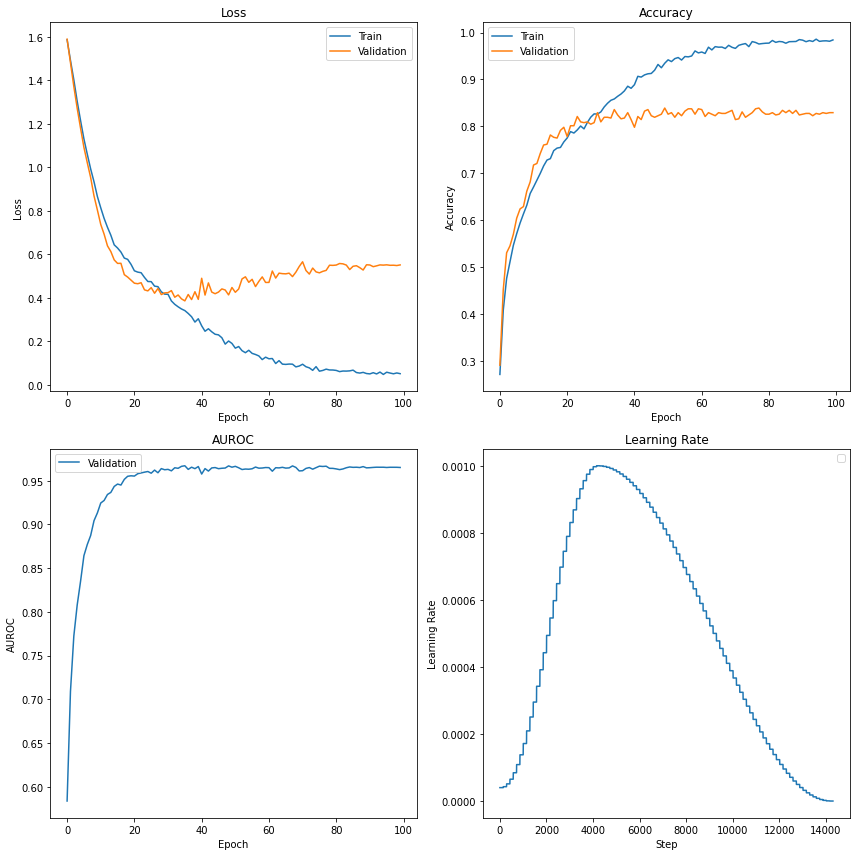

In [15]:
model, total_train_accuracy, total_train_loss, total_train_auroc, total_val_accuracy, total_val_loss, total_val_auroc = train(
    model,
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs,
    early_stopping=early_stopping,
    model_checkpoint_path=model_checkpoint_path,
    model_name=model_name,
    tensorboard_dir=tensorboard_dir, 
    log_file_dir=log_file_dir
)

In [16]:
torch.cuda.empty_cache()
!nvidia-smi

Sat Sep 23 15:55:35 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.98                 Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               On  | 00000000:57:00.0 Off |                  Off |
| 30%   31C    P2              41W / 230W |   2437MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Visualize some validation set prediction results

In [17]:
def visualize_model(model, num_imgs=4):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(image_dataloader['val']):
            inputs = inputs.to(device)
            labels = torch.tensor([label_map[label] for label in labels]).to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_imgs // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('Predicted: {}'.format(image_datasets['val'].class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_imgs:
                    model.train(mode=was_training)
                    return

    model.train(mode=was_training)


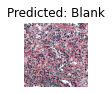

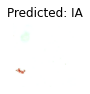

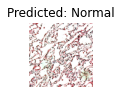

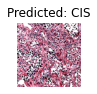

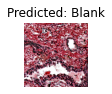

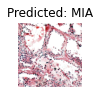

In [18]:
# Set up label_map 
label_map = {
    'Blank': 0,
    'Normal': 1,
    'CIS': 2,
    'MIA': 3,
    'IA': 4
}

label_map_inv = {v: k for k, v in label_map.items()}  # Define inverse mapping

visualize_model(model, num_imgs=6)

plt.ioff()
plt.show()

# Evaluation

In [19]:
import csv
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

def evaluate(model, criterion, dataloader, csv_path=None):
    model.eval()
    loss = 0.0
    corrects = 0
    all_predictions = []  # List to store predicted probabilities
    all_labels = []  # List to store true labels
    result_rows = []  # List to store evaluation results

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluation'):
            inputs = inputs.to(device)
            labels = torch.tensor([label_map[label] for label in labels]).to(device)  # Convert labels to numerical values

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            batch_loss = criterion(outputs, labels)

            loss += batch_loss.item() * inputs.size(0)
            corrects += torch.sum(preds == labels.data)

            predictions = torch.softmax(outputs, dim=1)
            all_predictions.append(predictions.detach().cpu().numpy())
            all_labels.append(labels.detach().cpu().numpy())

            if csv_path is not None:
                for i in range(inputs.size(0)):
                    row = [
                        label_map_inv[labels[i].item()],
                        label_map_inv[preds[i].item()],
                    ]
                    row.extend(predictions[i].tolist())  # Add probabilities to the row
                    result_rows.append(row)

    total_loss = loss / len(dataloader.dataset)
    accuracy = corrects.float() / len(dataloader.dataset)

    all_predictions = np.concatenate(all_predictions)
    all_labels = np.concatenate(all_labels)

    if csv_path is not None:
        with open(csv_path, 'w', newline='') as file:
            writer = csv.writer(file)
            header = ['True Label', 'Predicted Label']
            header.extend([f'Probability {label}' for label in label_map_inv.values()])  # Add probability headers
            writer.writerow(header)
            writer.writerows(result_rows)

    # Compute metrics
    confusion = confusion_matrix(all_labels, np.argmax(all_predictions, axis=1))
    classification = classification_report(all_labels, np.argmax(all_predictions, axis=1))

    # Compute ROC AUC score (macro and weighted)
    num_classes = all_predictions.shape[1]
    roc_auc_macro = roc_auc_score(all_labels, all_predictions, multi_class='ovr', average='macro')
    roc_auc_weighted = roc_auc_score(all_labels, all_predictions, multi_class='ovr', average='weighted')

    # Compute ROC curve and AUROC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot AUROC curve
    plt.figure()
    colors = ['blue', 'orange', 'green', 'red', 'brown']  # Add another color for the fourth class
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {label_map_inv[i]} (AUROC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    # Print the metrics
    print("Confusion Matrix:")
    print(confusion)
    print("\nClassification Report:")
    print(classification)
    print("\nROC AUC (Macro): {:.5f}".format(roc_auc_macro))
    print("ROC AUC (Weighted): {:.5f}".format(roc_auc_weighted))

    return total_loss, accuracy


/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/root/miniconda3/lib/python3.8/site-packages/torchvision/ops/misc.py:114: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(
Evaluation: 100%|██████████| 41/41 [01:59<00:00,  2.93s/it]


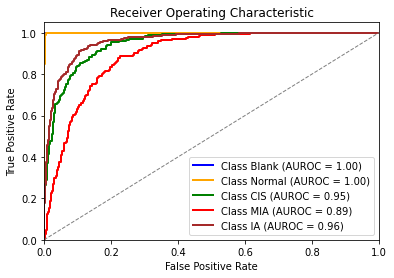

Confusion Matrix:
[[271   1   0   0   0]
 [  0 166   0   0   0]
 [  1  10 149  53  15]
 [  0   0  28 132  44]
 [  0   1   8  57 284]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       272
           1       0.93      1.00      0.97       166
           2       0.81      0.65      0.72       228
           3       0.55      0.65      0.59       204
           4       0.83      0.81      0.82       350

    accuracy                           0.82      1220
   macro avg       0.82      0.82      0.82      1220
weighted avg       0.83      0.82      0.82      1220


ROC AUC (Macro): 0.96015
ROC AUC (Weighted): 0.96081
Test Loss: 0.47799 Accuracy: 0.82131


In [20]:
# Evaluate the model
model_path = '/root/autodl-nas/TXY/models/EfficientNet_b5_best_model.pt'
model_dict = torch.load(model_path, map_location=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
# print(model_dict)

# Set up label_map 
label_map = {
    'Blank': 0,
    'Normal': 1,
    'CIS': 2,
    'MIA': 3,
    'IA': 4
}

label_map_inv = {v: k for k, v in label_map.items()}  # Define inverse mapping

# Modify the last fully connected layer
num_classes = 5  # Number of classes in your dataset

#Load pretrained EfficientNet_b5 model
model = torchvision.models.efficientnet_b5(pretrained=False)
model.features[0] = ConvNormActivation(
    in_channels=3, 
    out_channels=48,
    kernel_size=3,
    stride=2,
    norm_layer=partial(nn.BatchNorm2d, eps=0.001, momentum=0.01),
    activation_layer=nn.SiLU)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=2048, out_features=num_classes, bias=True))

# Load the weight from the saved pt file
model.load_state_dict(model_dict)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()

csv_path = '/root/autodl-nas/TXY/models/test_evaluation_results.csv'  # Provide the desired path for the CSV file
test_loss, test_accuracy = evaluate(model, criterion, image_dataloader['test'], csv_path)
print('Test Loss: {:.5f} Accuracy: {:.5f}'.format(test_loss, test_accuracy))


# Evaluation of the external dataset

In [ ]:
# Load CSV files and get labels
import os
import random
import json

# Enable interactive mode
plt.ion()

# Define paths
dataset_path = "/root/autodl-nas/TXY/food/train"
labels_path = "/root/autodl-nas/TXY/food/Training_set_food.csv"

# Define saved json file path
csv_json_path = "/root/autodl-nas/TXY/food/external_dataset.json"

# Load labels and file names from CSV
import pandas as pd
csv_file = pd.read_csv(labels_path)
file_names = csv_file['filename'].tolist()

# Calculate the number of samples
total_samples = len(file_names)

# Function to find the label for a given file name
def find_label(file_name):
    return csv_file.loc[csv_file['filename'] == file_name, 'label'].values[0]

# Function to get the file path given the file name
def get_file_path(file_name):
    for root, dirs, files in os.walk(dataset_path):
        if file_name in files:
            return os.path.abspath(os.path.join(root, file_name))

# Create dictionaries
csv_dict = []

# Fill the dictionaries with file paths and labels
for file_name in file_names:
    label = find_label(file_name)
    file_path = get_file_path(file_name)  # Complete file path
    csv_dict.append({"file_name": file_name, "file_path": file_path, "label": label})

# Save the dictionaries as separate JSON files
with open(csv_json_path, 'w') as csv_file:
    json.dump(csv_dict, csv_file)

# Print the summary
print(f"Total samples: {total_samples}")
print(f"External set JSON file saved to: {csv_json_path}")


In [ ]:
import json
import torch
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Define the transformations and augmentation for train and val sets
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to a fixed size
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=mean_list, std=std_list),  # Normalize the image
])

class CustomDataset(Dataset):
    def __init__(self, json_path, transform=None):
        self.data = []
        self.transform = transform
        self.img_paths = []
        self.labels = []

        # Load the JSON file
        with open(json_path, 'r') as f:
            json_data = json.load(f)
        
        # Process each item in the JSON file
        for item in json_data:
            image_path = item['file_path']
            label = item['label']
            self.data.append((image_path, label))
            self.img_paths.append(image_path)
            self.labels.append(label)
        
        # Get the class names from the JSON file
        self.class_names = list(set(item['label'] for item in json_data))
    
    def __getitem__(self, index):
        image_path, label = self.data[index]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label
    
    def __len__(self):
        return len(self.data)

    
# Set up batch size
batch_size = 30

# Create datasets and data loaders
ex_image_datasets = CustomDataset(csv_json_path, transform=val_transform) # Use val_transform for test as an example
ex_image_dataloader = DataLoader(ex_image_datasets, batch_size=batch_size)


# Get the sizes of the dataset
ex_dataset_sizes = len(ex_image_datasets)

# Get the class names
ex_class_names = ex_image_datasets.class_names

# Print the sizes of the external datasets and class names
print("External dataset size:", ex_dataset_sizes)
print("Class names-External set:", ex_class_names)


In [ ]:
# Set up label_map as the same to previous setting

label_map = {
    'Blank': 0,
    'Normal': 1,
    'CIS': 2,
    'MIA': 3,
    'IA': 4
}

label_map_inv = {v: k for k, v in label_map.items()}  # Define inverse mapping

In [ ]:
# Evaluate external new dataset

# Evaluate the model
model_path = '/root/autodl-nas/TXY/models/EfficientNet_b5_best_model.pt'
model_dict = torch.load(model_path, map_location=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))
# print(model_dict)

# Modify the last fully connected layer
num_classes = 5  # Number of classes in your dataset

#Load pretrained EfficientNet_b5 model
model = torchvision.models.efficientnet_b5(pretrained=True)
model.features[0] = ConvNormActivation(
    in_channels=3, 
    out_channels=48,
    kernel_size=3,
    stride=2,
    norm_layer=partial(nn.BatchNorm2d, eps=0.001, momentum=0.01),
    activation_layer=nn.SiLU)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=2048, out_features=num_classes, bias=True))

# Load the weight from the saved pt file
model.load_state_dict(model_dict)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()

csv_path = '/root/autodl-nas/TXY/models/external_evaluation_results.csv'  # Provide the desired path for the CSV file

# Image dataloading in the external dataset
test_loss, test_accuracy = evaluate(model, criterion, ex_image_dataloader, csv_path)
print('Test Loss: {:.5f} Accuracy: {:.5f}'.format(test_loss, test_accuracy))



In [ ]:
!python3 -m tensorboard.main --logdir=/root/autodl-nas/TXY/tensorbord